# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']

In [4]:
# Pick the celltype for the celltype-specific training
ct = cts[0]; ct

'HEPG2'

In [5]:
xb = np.load('pred/feats_train_'+ct+'.npy')
yb = np.load('pred/targs_train_'+ct+'.npy')
xq = np.load('pred/feats_valid_'+ct+'.npy')
yq = np.load('pred/targs_valid_'+ct+'.npy')

In [6]:
xb.shape # nb-by-d

(33000, 512)

In [7]:
xq.shape # nq-by-d (query vectors)

(4428, 512)

In [8]:
yb.shape, yq.shape

((33000,), (4428,))

In [9]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 726)

In [10]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [11]:
xb.max()

80.598526

In [12]:
faiss.normalize_L2(xb)

In [13]:
xb.max()

0.44533476

In [14]:
index.train(xb)

In [15]:
index.add_with_ids(xb, yb)

In [16]:
print(index.is_trained)
print(index.ntotal)

True
33000


## Train dataset

In [17]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[973 973 973 973 973]
 [621 621 621 621 621]
 [761 761 761 761 761]
 [651 651 651 651 651]
 [ 91  91  91  91  91]]
[[973]
 [621]
 [761]
 [651]
 [ 91]]
[[1.0000001  0.9983117  0.9970636  0.99672085 0.9961188 ]
 [1.         0.99591094 0.9917218  0.9904805  0.9899041 ]
 [0.9999999  0.9952432  0.99351627 0.9928811  0.9924984 ]
 [1.         0.9959123  0.99554193 0.99440503 0.99293756]
 [0.99999994 0.90579605 0.89782333 0.8762014  0.8759    ]]


In [18]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [19]:
I_train[:,0].shape, yb.shape

((33000,), (33000,))

In [20]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [21]:
I_train[:10,0], yb[:10]

(array([ 973,  621,  761,  651,   91, 1013,  892,  356,  233,  572]),
 array([ 973,  621,  761,  651,   91, 1013,  892,  356,  233,  572]))

In [22]:
I_train[-10:,0], yb[-10:]

(array([600, 160, 941, 329, 135, 135, 445, 374,  65, 916]),
 array([600, 160, 941, 329, 135, 135, 445, 374,  65, 916]))

### Train confusion matrix

In [23]:
#cm = confusion_matrix(I_train[:,0], yb)

In [24]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [25]:
xq.max()

72.657166

In [26]:
faiss.normalize_L2(xq)

In [27]:
xq.max()

0.43989527

In [28]:
D_valid, I_valid = index.search(xq, k) # actual search

In [29]:
xq.shape, yq.shape

((4428, 512), (4428,))

In [30]:
I_valid.shape, D_valid.shape

((4428, 5), (4428, 5))

In [31]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 523  523  523  523  523]
 [ 744  744  744  744  744]
 [ 503  503  503  503  503]
 [ 415  810  810  810  810]
 [1056 1056  715 1056  715]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.8576547  0.8045316  0.7406448  0.7235943  0.7225721 ]
 [0.7024647  0.6771134  0.6676321  0.65353966 0.6472436 ]
 [0.9488984  0.9460268  0.9423168  0.93871176 0.9370488 ]
 [0.7958113  0.78989536 0.777227   0.77660316 0.7692504 ]
 [0.7936309  0.7437617  0.7202615  0.718453   0.71434736]]


In [32]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 18  18  18  18  18]
 [137 137 137 137 137]
 [249 249 249 249 249]
 [292 292 292 292 292]
 [994 994 994 994 994]]
[[ 18]
 [156]
 [261]
 [ 14]
 [994]]
[[0.9118911  0.8672601  0.8534877  0.8529419  0.85268664]
 [0.79587424 0.7919588  0.78499794 0.78459334 0.7825289 ]
 [0.8041663  0.79723954 0.78381395 0.77518404 0.7723359 ]
 [0.56549454 0.5586083  0.53934735 0.5239078  0.5193989 ]
 [0.8023077  0.80161273 0.7801218  0.76226485 0.75786376]]


In [33]:
np.save('pred/preds_valid_'+ct+'.npy', I_valid)

### Valid accuracy

In [34]:
I_valid[:,0]

array([523, 744, 503, ..., 249, 292, 994])

In [35]:
yq

array([352, 361, 503, ..., 261,  14, 994])

In [36]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

2268

In [37]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.5121951219512195

In [38]:
valid_correct = np.equal(I_valid[:,0], yq)

In [39]:
valid_correct

array([False, False,  True, ..., False, False,  True])

In [40]:
np.save('pred/preds_valid_correct_'+ct+'.npy', valid_correct)

### Valid confusion matrix

In [41]:
cm = confusion_matrix(I_valid[:,0], yq)

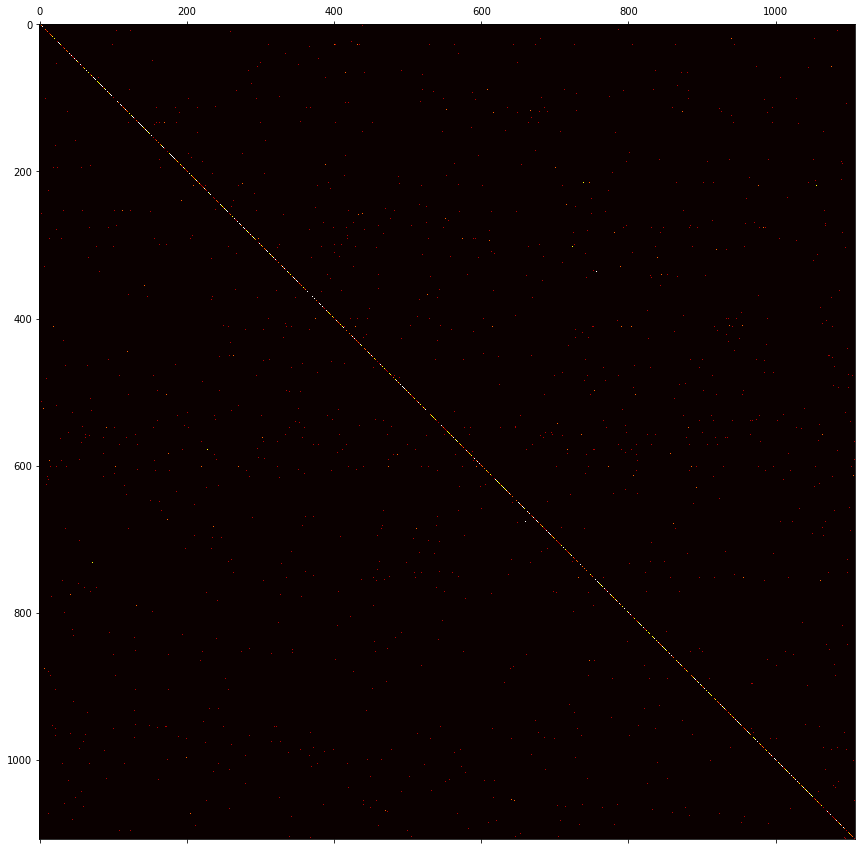

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [44]:
xq_test = np.load('pred/feats_test_'+ct+'.npy')

In [45]:
xq_test.max()

72.06567

In [46]:
faiss.normalize_L2(xq_test)

In [47]:
xq_test.max()

0.42492905

In [48]:
D_test, I_test = index.search(xq_test, k) # actual search

In [49]:
xq_test.shape, I_test.shape, D_test.shape

((17692, 512), (17692, 5), (17692, 5))

In [50]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[290 290 290 290 290]
 [450 450 450 450 450]
 [301 301 301 301 301]
 [272 272 272 272 272]
 [784 784 784 784 784]]
[[0.8426341  0.8346358  0.8303456  0.8271711  0.82687783]
 [0.86446714 0.85302776 0.8519254  0.85031766 0.82438874]
 [0.80268097 0.79605085 0.7953719  0.79484165 0.79316264]
 [0.6795601  0.6763804  0.66702247 0.66432846 0.66264683]
 [0.9292484  0.8995203  0.89823246 0.89669037 0.896407  ]]


In [51]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[1071 1071 1071 1071 1071]
 [ 627  627  627  627  627]
 [ 926  926  926  926  926]
 [ 490  490  490  490  490]
 [ 933  933  933  933  933]]
[[0.9239906  0.92377234 0.92149    0.9212239  0.918093  ]
 [0.9946598  0.99457836 0.9942728  0.9941925  0.99417114]
 [0.98404086 0.98307884 0.98299676 0.98147225 0.9794351 ]
 [0.9888414  0.9876228  0.98727983 0.9872227  0.9855598 ]
 [0.80651104 0.7952711  0.783677   0.78329957 0.7765067 ]]


In [52]:
I_test[2]

array([301, 301, 301, 301, 301])

In [53]:
np.unique(I_test[2], return_counts=True)

(array([301]), array([5]))

In [54]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [55]:
np.save('pred/preds_test_'+ct+'.npy', preds_test)
np.save('pred/dist_test_'+ct+'.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)